In [9]:
from ppktstore.registry import configure_phenopacket_registry
from ppktstore.model import DefaultPhenopacketStore
from ppktstore.release.stats import PPKtStoreStats
import phenopackets as ppkt
import typing

# Import cohort via phenopacket-store-toolkit

## Method 1

In [10]:
from ppkt2synergy import CohortManager
phenopackets = CohortManager.from_ppkt_store(cohort_name='FBN1', ppkt_store_version="0.1.23")
print(phenopackets[5])

id: "PMID_12203992_Patient_B1"
subject {
  id: "Patient B1"
  time_at_last_encounter {
    age {
      iso8601duration: "P8Y"
    }
  }
  vital_status {
  }
  sex: MALE
}
phenotypic_features {
  type {
    id: "HP:0001166"
    label: "Arachnodactyly"
  }
}
phenotypic_features {
  type {
    id: "HP:0000218"
    label: "High palate"
  }
}
phenotypic_features {
  type {
    id: "HP:0000678"
    label: "Dental crowding"
  }
}
phenotypic_features {
  type {
    id: "HP:0001377"
    label: "Limited elbow extension"
  }
}
phenotypic_features {
  type {
    id: "HP:0002616"
    label: "Aortic root aneurysm"
  }
}
phenotypic_features {
  type {
    id: "HP:0001083"
    label: "Ectopia lentis"
  }
}
phenotypic_features {
  type {
    id: "HP:0000545"
    label: "Myopia"
  }
}
phenotypic_features {
  type {
    id: "HP:0000268"
    label: "Dolichocephaly"
  }
}
phenotypic_features {
  type {
    id: "HP:0001634"
    label: "Mitral valve prolapse"
  }
}
phenotypic_features {
  type {
    id: "HP:

In [11]:
print(f"Number of patients by FBN1: {len(phenopackets)}")

Number of patients by FBN1: 144


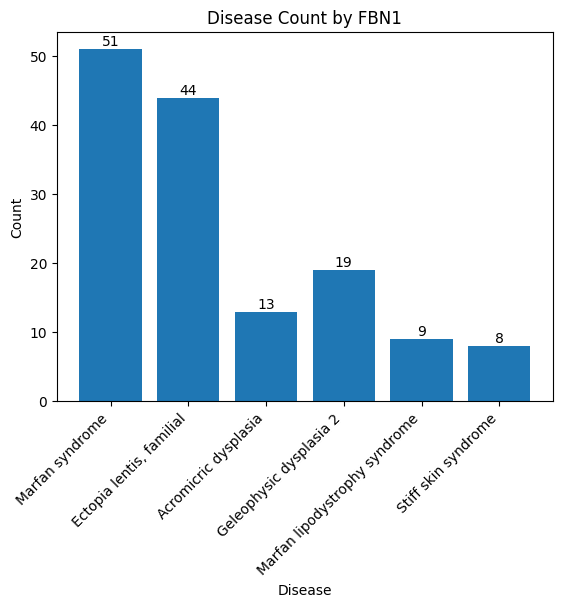

In [12]:
from collections import Counter
import matplotlib.pyplot as plt

def diseases_count_table(phenopackets:typing.List[ppkt.Phenopacket]) -> typing.Dict[str, int]:
    """ 
    Returns:
        A dictionary with key=disease label and value=number of phenopackets in the cohort with the disease
    """
    diseases= []
    for phenopacket in phenopackets:
        if len(phenopacket.diseases) == 0:
            raise ValueError("Empty disease list")
        if len(phenopacket.diseases) != 1:
            print("Warning, number of diseases ", len(phenopacket.diseases))
        #if len(phenopacket.diseases) == 1:
        diseases.append(phenopacket.diseases[0].term.label)
    return Counter(diseases)

diseases_count = diseases_count_table(phenopackets)

labels = list(diseases_count.keys())
counts = list(diseases_count.values())

# plot graph to show diseases and count
plt.bar(labels, counts)
plt.xlabel('Disease')
plt.ylabel('Count')
plt.title('Disease Count by FBN1')
plt.xticks(rotation=45, ha="right") 
for i, count in enumerate(counts):
    plt.text(i, count + 0.1, str(count), ha='center', va='bottom') 
plt.show()



In [13]:
def HPO_count_table(phenopackets: list) -> int:
    HPOs= list()
    for phenopacket in phenopackets:
        if len(phenopacket.phenotypic_features) == 0:
            raise ValueError("Empty disease list")
        for phenotype in phenopacket.phenotypic_features:
            HPOs.append(phenotype.type.label)
        distribution = Counter(HPOs)
    return len(set(HPOs)),distribution

HPOs_count, distribution = HPO_count_table(phenopackets)
print(f'Number of distinct HPOs by FBN1: {HPOs_count}')
print(distribution)

Number of distinct HPOs by FBN1: 109
Counter({'Joint hypermobility': 118, 'Mitral valve prolapse': 113, 'Ectopia lentis': 109, 'Pectus excavatum': 104, 'Arachnodactyly': 103, 'Aortic root aneurysm': 97, 'Scoliosis': 93, 'High palate': 89, 'Myopia': 88, 'Pectus carinatum': 88, 'Tall stature': 88, 'Retinal detachment': 83, 'Striae distensae': 75, 'Mitral regurgitation': 70, 'Short stature': 62, 'Stiff skin': 59, 'Disproportionate tall stature': 51, 'Deeply set eye': 47, 'Dolichocephaly': 46, 'Aortic regurgitation': 43, 'Glaucoma': 43, 'Reduced upper to lower segment ratio': 42, 'Aortic aneurysm': 41, 'Pes planus': 37, 'Dental crowding': 33, 'Limited elbow extension': 33, 'Lens coloboma': 33, 'Inguinal hernia': 33, 'Malar flattening': 33, 'Short foot': 32, 'Short palm': 32, 'Mitral stenosis': 31, 'Tricuspid stenosis': 31, 'Aortic valve stenosis': 31, 'Strabismus': 30, 'Severe short stature': 29, 'Moderately short stature': 29, 'Mild short stature': 29, 'Ascending aortic dissection': 28, '

## Method 2

In [15]:
def filter_cohorts(
    store: DefaultPhenopacketStore,
    cohort_names: typing.List[str]
) -> DefaultPhenopacketStore:
    """
    Filter cohorts from a DefaultPhenopacketStore by specified cohort names.

    :param store: Original DefaultPhenopacketStore instance.
    :param cohort_names: List of cohort names to include in the new store.
    :return: A new DefaultPhenopacketStore containing only the specified cohorts.
    """
    # Filter the cohorts based on the provided list of cohort names
    filtered_cohorts = [
        cohort for cohort in store.cohorts() if cohort.name in cohort_names
    ]

    # Return a new DefaultPhenopacketStore with the filtered cohorts
    return DefaultPhenopacketStore(
        name=f"{store.name}_filtered",  
        path=store.path, 
        cohorts=filtered_cohorts,  # only the filtered cohorts
    )


registry = configure_phenopacket_registry()
with registry.open_phenopacket_store(release="0.1.22") as ps:
    phenopackets = filter_cohorts(
    store=ps,  
    cohort_names=["FBN1"]  # Build a new phenopacketstore with cohort FBN1
    )
    stats = PPKtStoreStats(phenopackets)
    df = stats.get_summary_df()
    print(df.head())
    print(f'Number of patients by FBN1: {df.shape[0]}')
    diseases_count = stats.get_counts_per_disease_df()
    print(f'Number of Diseases by FBN1: {diseases_count}')
    HPOs_count = stats._get_total_and_unique_hpo_counts(phenopackets)
    print(f'Number of distinct HPOs by FBN1: {HPOs_count}')


     patient_id cohort   disease_id                   disease  gene  \
0   Patient D62   FBN1  OMIM:154700           Marfan syndrome  FBN1   
1   Patient B47   FBN1  OMIM:154700           Marfan syndrome  FBN1   
2     Patient 4   FBN1  OMIM:129600  Ectopia lentis, familial  FBN1   
3   Patient D19   FBN1  OMIM:154700           Marfan syndrome  FBN1   
4  AD Family 20   FBN1  OMIM:102370      Acromicric dysplasia  FBN1   

                  allele_1 allele_2           PMID  \
0    NM_000138.5:c.2047T>C           PMID:12203992   
1    NM_000138.5:c.3058A>G           PMID:11175294   
2    NM_000138.5:c.1879C>T           PMID:33576469   
3  NM_000138.5:c.5422+1G>A           PMID:12203992   
4    NM_000138.5:c.5182G>A           PMID:21683322   

                                            filename  
0  C:\Users\Lenovo\phenopacket-store\0.1.22.zip/....  
1  C:\Users\Lenovo\phenopacket-store\0.1.22.zip/....  
2  C:\Users\Lenovo\phenopacket-store\0.1.22.zip/....  
3  C:\Users\Lenovo\phenopack

# CohortHPO Correlation Test

In [4]:
import scipy.stats
from typing import Union
import numpy as np
from sklearn.metrics import matthews_corrcoef

def get_status_for_terms(patient, hpo_id_A: str, hpo_id_B: str) -> Union[tuple, None]:
    """
    Checks the statuses (observed or excluded) of two HPO term IDs in a patient's phenotype data.

    Args:
        phenotype: A PhenotypicFeature object containing the patient's phenotype data.
        hpo_id_A: The first HPO term ID to check.
        hpo_id_B: The second HPO term ID to check.

    Returns:
        tuple: A tuple (status_A, status_B) where each status is:
            - 1 if the phenotype is observed (not excluded).
            - 0 if the phenotype is excluded.
            - None if the HPO term is not present in the phenotype.
    """
    status_A = status_B = None

    for phenotype_feature in patient.phenotypic_features:
        if phenotype_feature.type.id == hpo_id_A:
            status_A = 0 if phenotype_feature.excluded else 1
        elif phenotype_feature.type.id == hpo_id_B:
            status_B = 0 if phenotype_feature.excluded else 1
    
        # Early stop if both statuses are found
        if status_A is not None and status_B is not None:
            return status_A, status_B    

    return None


def calculate_mcc_and_p(observed_status_A:list, observed_status_B:list)->tuple:
    """
    Calculate the Matthews Correlation Coefficient (MCC) and its associated p-value using a contingency table and chi-square test.

    Args:
        observed_status_A: List of 0/1 values for variable A.
        observed_status_B: List of 0/1 values for variable B.

    Returns:
        tuple: (mcc, p_value)
    """
    contingency_table = np.array([
        [sum((np.array(observed_status_A) == 1) & (np.array(observed_status_B) == 1)),
         sum((np.array(observed_status_A) == 1) & (np.array(observed_status_B) == 0))],
        [sum((np.array(observed_status_A) == 0) & (np.array(observed_status_B) == 1)),
         sum((np.array(observed_status_A) == 0) & (np.array(observed_status_B) == 0))]
    ])
    chi2, p_value, _, _ = scipy.stats.chi2_contingency(contingency_table)
    mcc = matthews_corrcoef(observed_status_A, observed_status_B)
    return mcc, p_value


def test_hpo_terms(cohort: str, hpo_id_A: str, hpo_id_B: str):
    """
    Perform correlation tests (Spearman and MCC) between two HPO terms in a cohort of patients.

    Args:
        cohort: The name of the patient cohort to analyze.
        hpo_id_A: The first HPO term ID to correlate.
        hpo_id_B: The second HPO term ID to correlate.
        url: The URL of the HPO ontology in JSON format.

    Returns:
        dict: A dictionary containing correlation coefficients and p-values for each test.
        If the data is insufficient (< 30 samples), an error message is returned.
    """
   
    observed_status_A = []
    observed_status_B = []
    
    # Import cohort
    registry = configure_phenopacket_registry()
    with registry.open_phenopacket_store(release="0.1.23") as ps:
        patients = list(ps.iter_cohort_phenopackets(cohort))
     
    for patient in patients:
        result = get_status_for_terms(patient, hpo_id_A, hpo_id_B)
        if result is not None:
            status_A, status_B = result
            observed_status_A.append(status_A)
            
            observed_status_B.append(status_B)

    # If the number of observed data points is less than 30, return an error message. 
    # This threshold ensures sufficient statistical power for reliable correlation tests.
    if len(observed_status_A) < 30:
        return {"error": "Not enough data for correlation tests"}

    # Spearman test
    spearman_corr, spearman_p = scipy.stats.spearmanr(observed_status_A, observed_status_B)

    # MCC
    mcc, mcc_p = calculate_mcc_and_p(observed_status_A, observed_status_B)

    return {
        "Spearman": {"correlation": spearman_corr, "p_value": spearman_p},
        "MCC": {"correlation": mcc, "p_value": mcc_p}
    }

In [4]:
import hpotk
import pandas as pd

def generate_hpo_term_status_matrix(cohort: str) -> pd.DataFrame:
    """
    Generate a binary matrix of HPO term statuses for all patients in a cohort.

    Args:
        cohort: The patient cohort, a collection of patient objects with phenotypic features.

    Returns:
        A pandas DataFrame:
            - Rows represent patients (indexed by their IDs).
            - Columns represent unique HPO IDs (sorted alphabetically).
            - Values are binary (1: observed, 0: excluded).
    """

    registry = configure_phenopacket_registry()
    with registry.open_phenopacket_store(release="0.1.23") as ps:
        patients = list(ps.iter_cohort_phenopackets(cohort))
    hpo_ids = set()
    status_data = {}

    # Single pass to collect HPO IDs and patient statuses
    for patient in patients:
        status_data[patient.id] = {}
        for feature in patient.phenotypic_features:
            hpo_id = feature.type.id
            hpo_ids.add(hpo_id)
            status_data[patient.id][hpo_id] = 0 if feature.excluded else 1

    # Create a sorted list of unique HPO IDs
    hpo_ids = sorted(hpo_ids)

    # Convert the status_data dictionary to a DataFrame
    status_matrix = pd.DataFrame.from_dict(status_data, orient='index', columns=hpo_ids)

    return status_matrix



def find_unrelated_hpo_terms(
        hpo_id: str, 
        cohort:str, 
        url= 'https://github.com/obophenotype/human-phenotype-ontology/releases/download/v2023-10-09/hp.json') -> dict:
    """
    Check if a given HPO ID  exists in the filtered terms_status DataFrame, where columns (HPO terms) with more than 50% missing values are removed.
    If it exists, return unrelated terms (terms not ancestors, descendants, or the term itself).
    If the term is not found, notify the user.

    Args:
        term: The HPO ID to check.
        cohort: The patient cohort to be analyzed.
        url: The URL or path to load the HPO ontology in JSON format.

    Returns:
        A dictionary with 'status' indicating success or failure, and 'data' containing the unrelated terms
        or a failure message.
    """
    # Load the HPO ontology
    hpo = hpotk.load_minimal_ontology(url)
    terms_status = generate_hpo_term_status_matrix(cohort)
    
    # Remove columns with None values exceeding 50%
    terms_status = terms_status.loc[:, terms_status.isna().mean() <= 0.5]

    # Check if the term exists in the filtered terms_status
    if hpo_id not in terms_status.columns:
        return {
            "error": f"The HPO term '{hpo_id}' was not found. It might not be relevant to this cohort or was excluded because it appears in less than 50% of patients. Please check the term and its applicability."

        }

    # Get ancestors and descendants of the term
    ancestors = hpo.graph.get_ancestors(hpo_id)
    descendants = hpo.graph.get_descendants(hpo_id)

    # Get unrelated terms
    related_terms = set(ancestors) | set(descendants) | {hpo_id}
    unrelated_terms = [col for col in terms_status.columns if col not in related_terms]

    return unrelated_terms

In [9]:
result = find_unrelated_hpo_terms("HP:0001634",'FBN1')
print(result)

['HP:0000098', 'HP:0000218', 'HP:0000541', 'HP:0000545', 'HP:0000767', 'HP:0000768', 'HP:0001065', 'HP:0001083', 'HP:0001166', 'HP:0001382', 'HP:0002616', 'HP:0002650']


In [ ]:
results = test_hpo_terms('FBN1', 'HP:0001634', 'HP:0001382')
print(results)
results = test_hpo_terms('FBN1', 'HP:0001634', 'HP:0000098')
print(results)
results = test_hpo_terms('FBN1', 'HP:0001634', 'HP:0000218')
print(results)

In [2]:
from ppkt2synergy import CohortStats
cohortstats = CohortStats(cohort_name='DHCR24', ppkt_store_version="0.1.23")

In [26]:
for colum in cohortstats.generate_hpo_term_status_matrix().columns.drop(['HP:0000773','HP:0004322','HP:0008905']):
    print(len(cohortstats.find_unrelated_hpo_terms(hpo_id=colum)))


25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25


In [3]:
cohortstats.test_hpo_terms('HP:0004322', 'HP:0000341')

Error: Not enough valid data (less than 5 rows) to perform the analysis.


ValueError: Not enough valid data (less than 5 rows) to perform the analysis.

In [4]:
cohortstats.generate_hpo_term_status_matrix()


,HP:0000175,HP:0000252,HP:0000256,HP:0000268,HP:0000286,HP:0000341,HP:0000347,HP:0000369,HP:0000470,HP:0000486,...,HP:0001883,HP:0002007,HP:0002119,HP:0004322,HP:0005160,HP:0005684,HP:0008905,HP:0011001,HP:0034295,HP:0034937
PMID_29175559_Patient_8_Dias_2014,1,0,0,1,0,1,1,1,1.0,1.0,...,0.0,0.0,1,1.0,NaN,NaN,NaN,0,1.0,1
PMID_29175559_Patient_9_Dias_2014,0,0,0,1,0,1,0,1,0.0,1.0,...,1.0,0.0,1,1.0,0.0,1.0,0.0,0,1.0,1
PMID_29175559_Patient_3_Zolotushko_2011_V1,0,1,0,0,0,0,1,0,0.0,1.0,...,NaN,0.0,1,NaN,0.0,1.0,NaN,0,1.0,1
PMID_29175559_Patient_4_Zolotushko_2011_V4,0,1,0,0,0,0,1,0,NaN,0.0,...,NaN,0.0,1,NaN,NaN,NaN,NaN,0,1.0,1
PMID_29175559_Patient_6_Zolotushko_2011_IV5,0,1,0,0,0,0,1,0,NaN,1.0,...,NaN,0.0,1,NaN,NaN,NaN,NaN,0,1.0,1
PMID_29175559_Patient_7_Schaaf_2011,0,0,0,0,0,0,1,0,0.0,0.0,...,1.0,NaN,1,NaN,0.0,1.0,1.0,0,1.0,1
PMID_29175559_Patient_5_Zolotushko_2011_V7,0,1,0,0,0,0,1,0,NaN,1.0,...,NaN,0.0,1,NaN,NaN,NaN,NaN,0,1.0,1
PMID_29175559_Patient_1_FitzPatrick_1998,1,0,1,0,0,0,1,1,0.0,NaN,...,0.0,1.0,1,NaN,1.0,0.0,1.0,1,NaN,1
PMID_29175559_Present_patient,1,0,0,0,0,0,1,1,1.0,1.0,...,1.0,0.0,1,1.0,0.0,1.0,0.0,0,0.0,1
PMID_29175559_Patient_2_Andersson_2002,1,1,0,0,1,0,1,0,0.0,0.0,...,1.0,0.0,0,1.0,0.0,1.0,0.0,0,1.0,1


In [2]:
cohortstats.test_hpo_terms('HP:0001634', 'HP:0001382')
cohortstats.test_hpo_terms('HP:0001634', 'HP:0000098')
cohortstats.test_hpo_terms('HP:0001634', 'HP:0000218')

{'Spearman': 0.34871490092681423,
 'Spearman_p_value': 0.002168726652821395,
 'MCC': 0.3487149009268143,
 'MCC_p_value': 0.006124831856429692}

In [14]:
import hpotk
hpo = hpotk.load_minimal_ontology("D:\\storage\\Master_Thesis\\hp.json")
ancestors = hpo.graph.is_ancestor_of("HP:0000218", "HP:0000175")
descendants = hpo.graph.is_descendant_of("HP:0000218", "HP:0000175")
print(ancestors,descendants)
print(list(hpo.graph.get_ancestors("HP:0000218")))

False False
[DefaultTermId(idx=2, value=HP_0000174), DefaultTermId(idx=2, value=HP_0000163), DefaultTermId(idx=2, value=HP_0031816), DefaultTermId(idx=2, value=HP_0000153), DefaultTermId(idx=2, value=HP_0000271), DefaultTermId(idx=2, value=HP_0000234), DefaultTermId(idx=2, value=HP_0000152), DefaultTermId(idx=2, value=HP_0000118), DefaultTermId(idx=2, value=HP_0000001)]


In [ ]:
import os
from pyphetools.creation import TemplateImporter
import phenopackets.schema.v2.core.meta_data.proto

metadata = meta_data(
    created_by="0000-0002-0736-9199",
    creation_date="2025-01-21"
)

# Path to the folder containing the input .xlsx files
input_folder = "test/data/input"
# Path to the folder where the output .json files will be saved
output_folder = "test/data/cohorts/FBN1"
os.makedirs(output_folder, exist_ok=True)  # Ensure the output folder exists

# ORCID identifier of the biocurator and the set of structural variants to handle
created_by = "0000-0002-0736-9199"

# Iterate over each file in the input folder
for file_name in os.listdir(input_folder):
    if file_name.endswith(".xlsx"):  
        template_path = os.path.join(input_folder, file_name) 
        
        # Import the template and create phenopackets
        timporter = TemplateImporter(template=template_path, created_by=created_by)
        individual_list, cvalidator = timporter.import_phenopackets_from_template()
        
        # Save each individual as a JSON file
        for individual in individual_list:
            output_file = os.path.join(output_folder, f"{individual.id}.json")  # Output path for the JSO
            with open(output_file, "w") as f:
                f.write(individual.to_ga4gh_phenopacket(metadata))  # Convert and save as GA4GH phenopacket JSON
            
        print(f"Processed {file_name} and saved JSON files to {output_folder}")


ImportError: cannot import name 'meta_data' from 'phenopackets.schema.v2.core' (unknown location)